In [1]:
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
import numpy as np
import pyamg
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter

In [2]:
n = 63
num_levels = 2
u_real = lambda x,y: np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
rightf = lambda x,y:  34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)
A = gallery.poisson((n, n))

解析解是$u_{real} = np.sin(np.pi*3*x)*np.sin(np.pi*5*y) $

右端项函数是$rightf = -34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)$

解析解画出来是:
    ![](pic1.png)

## GMM

In [3]:
x0 = np.random.randn(A.shape)
x = np.linspace(0, 1, num=n+1, endpoint=False)
y = np.linspace(0, 1, num=n+1, endpoint=False)
xx, yy = np.meshgrid(x[1:], y[1:])
x_true = u_real(xx,yy)
rhs = rightf(xx,yy)/ (n+1)**2
rhs = rhs.reshape(A.shape, 1)

In [4]:
linear_gmg = gmg_linear.LinearGMG(A, max_levels=num_levels)
print(linear_gmg)
GMM_rho = linear_gmg.compute_rho()
print("Spectral radius = {}".format(GMM_rho))

Dimension of matrix A for levels:
Level = 0, dimension = (31, 31)
Level = 1, dimension = (63, 63)

Spectral radius = 0.19705542477535856


[7.02562872e+00 1.01662127e+00 1.67777067e-01 2.92019535e-02
 5.23016997e-03 9.53070265e-04 1.75670126e-04 3.26431681e-05
 6.10267610e-06 1.14629692e-06 2.16130223e-07 4.08770221e-08
 7.75113895e-09 1.47299855e-09 2.80449151e-10 5.34826710e-11
 1.02137937e-11 1.95309328e-12 3.73983633e-13 7.19058815e-14
 1.57024320e-14 7.58904833e-15]


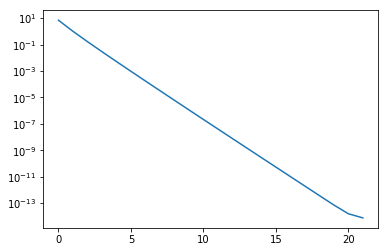

In [5]:
x = linear_gmg.solve(rhs, x0, tol=1e-14)
print(linear_gmg.get_gmg_convergence())
plt.semilogy(linear_gmg.get_gmg_convergence())

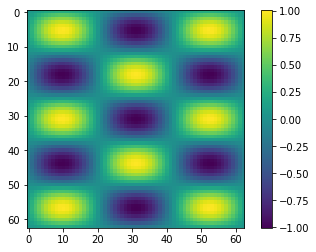

In [6]:
x = x.reshape(A.dim)
plt.imshow(x)
plt.colorbar()

## AMG

In [7]:
amg_solver = classical_amg.ClassicalAMG(A, num_levels)
AMG_rho = amg_solver.compute_rho()
print(amg_solver)
print("AMG spectral radius = {}".format(AMG_rho))

multilevel_solver
Number of Levels:     2
Operator Complexity:  1.886
Grid Complexity:      1.500
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0         3969        19593 [53.02%]
    1         1985        17361 [46.98%]

AMG spectral radius = 0.06172839506172778


[2.6216136690393608, 2.5249248090321825, 0.28054720100357616, 0.031171911222620682, 0.003463545691401611, 0.0003848384101548787, 4.275982334948444e-05, 4.751091481989498e-06, 5.278990534697823e-07, 5.86554498014832e-08, 6.51727192288217e-09, 7.241399650361682e-10, 8.045953171153422e-11, 8.938840949873923e-12, 9.933426159435193e-13, 1.0986660906118968e-13, 1.802583830903549e-14]


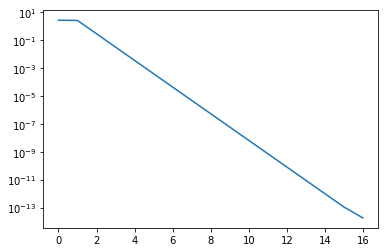

In [8]:
amg_solver = pyamg.classical.classical.ruge_stuben_solver(A.to_csr(), max_levels=num_levels, 
                                                                        max_coarse=1)
pyamg.relaxation.smoothing.change_smoothers(amg_solver,presmoother=("jacobi", {"omega": 2./3, "iterations": 2, "withrho": False}),postsmoother=("None"))
AMGres = []
x = amg_solver.solve(rhs, tol=1e-14,residuals=AMGres)
print(AMGres)
plt.semilogy(AMGres)

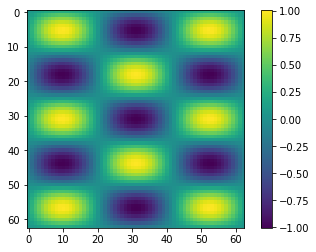

In [9]:
plt.imshow(x.reshape([n,n]))
plt.colorbar()

## DMM

In [10]:
x0 = np.random.randn(A.shape)
x = np.linspace(0, 1, num=n+1, endpoint=False)
y = np.linspace(0, 1, num=n+1, endpoint=False)
xx, yy = np.meshgrid(x[1:], y[1:])
rhs = rightf(xx,yy)/ (n+1)**2
rhs = rhs.reshape(A.shape, 1)

In [ ]:
PR_stencil_type = "m9p"
gmm = dgmg.DeepMG(A, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
num_iter = 2500
step_size = 1e-4
opt_par = gmm.optimize(num_iter=num_iter, step_size=step_size)

Iteration 100/2500
Upper bound estimation = 0.23223312704287247
Iteration 200/2500
Upper bound estimation = 0.22382554929167472
Iteration 300/2500
Upper bound estimation = 0.21108742760565155
Iteration 400/2500
Upper bound estimation = 0.20548589233909356
Iteration 500/2500
Upper bound estimation = 0.19783899054285506
Iteration 600/2500
Upper bound estimation = 0.19029830077190124
Iteration 700/2500
Upper bound estimation = 0.18325350533877213
Iteration 800/2500
Upper bound estimation = 0.17801962794926215
Iteration 900/2500
Upper bound estimation = 0.17246727428295355
Iteration 1000/2500
Upper bound estimation = 0.16591165676934783
Iteration 1100/2500
Upper bound estimation = 0.1607791160850267
Iteration 1200/2500
Upper bound estimation = 0.1556886453636721
Iteration 1300/2500
Upper bound estimation = 0.15797801442691464
Iteration 1400/2500
Upper bound estimation = 0.15370575934844777
Iteration 1500/2500
Upper bound estimation = 0.1527276177111879
Iteration 1600/2500
Upper bound estim

In [ ]:
print(gmm)
convergence = gmm.get_optimizer_convergence()
conv_time = gmm.get_optimization_time()
gmm.update_prd(opt_par)
DMM_rho = gmm.compute_rho()
print("DMM rho = {}".format(DMM_rho))

In [ ]:
x = gmm.solve(rhs, x0, tol=1e-14)
print(gmm.get_gmg_convergence())
plt.semilogy(gmm.get_gmg_convergence())

In [ ]:
x = x.reshape(A.dim)
plt.imshow(x)
plt.colorbar()

## Compare

In [ ]:
print("Radius of GMM={}".format(GMM_rho))
print("Radius of AMG={}".format(AMG_rho))
print("Radius of DMG={}".format(DMM_rho))

In [ ]:
plt.semilogy(linear_gmg.get_gmg_convergence(), label = 'GMM Residual')
plt.semilogy(AMGres,label = "AMG Residual")
plt.semilogy(gmm.get_gmg_convergence(), label = 'DMM Residual')
plt.legend(loc='upper right')

In [ ]:
print("GMM_rho : AMG_rho : DMM_rho = 1 : %f : %f" %(AMG_rho/GMM_rho,DMM_rho/GMM_rho))

## R, P and  $\omega$ after Optimization

The initial P, R in code is

P matrix:

[[0.25 0.5  0.25]

[0.5  1.   0.5 ]

[0.25 0.5  0.25]]

R matrix:

[[[0.0625 0.125  0.0625]

[0.125  0.25   0.125 ]

[0.0625 0.125  0.0625]]  

In [ ]:
np.set_printoptions(threshold=np.inf)
print("omega = {}".format(opt_par[2]))

In [ ]:
P = opt_par[0][0]
k = int(2**(np.log2(n+1)-1)-1) 
P_Matrix = np.zeros([n**2,k**2])
for i in range(k):
    for j in range(k):
        C = P[i][j]
        for l in range(3):
            for m in range(3):
                P_Matrix[n*(2*i+l)+(2*j+m)][k*i+j] = C[l][m]
workbook = xlsxwriter.Workbook('P_Poisson.xlsx')
worksheet = workbook.add_worksheet()
for col, data in enumerate(P_Matrix):
    worksheet.write_column(0, col, data)
workbook.close()

In [ ]:
R = opt_par[1][0]
R_Matrix = np.zeros([k**2,n**2])
for i in range(k):
    for j in range(k):
        C = R[i][j]
        for l in range(3):
            for m in range(3):
                R_Matrix[k*i+j][n*(2*i+l)+(2*j+m)] = C[l][m]
workbook = xlsxwriter.Workbook('R_Poisson.xlsx')
worksheet = workbook.add_worksheet()
for col, data in enumerate(R_Matrix):
    worksheet.write_column(0, col, data)
workbook.close()